# Frequency Assignment with Real Data

Lucerne University of Applied Sciences and Arts - School of Information Technology

@author: Tobias Mérinat and Marc Pouly

<img src="https://upload.wikimedia.org/wikipedia/en/5/59/Swisscom_logo.svg" width='150'/>

You are given part of the Swisscom LTE Antenna data. The file contains all existing neighboring relations as well as candidate relations for future cells for a selected area (not all of Switzerland). Your task is to assign a PCI (Physical Layer Cell ID) to each cell, without `collisions` and `confusions` and `minimize the number of PCIs`. PCIs can be between 0 and 503. More details can be found in the paper [Physical Cell ID Allocation in Cellular Networks](https://www.diva-portal.org/smash/get/diva2:940787/FULLTEXT01.pdf) by Sofia Nyberg. See page 2 for an explanation on collisions and confusions.

Collision | Confusion
--- | ---
<img src="collision.png" height='50'> | <img src="confusion.png" height='50'>

In the real world, there are also some additional constraints that we will not consider in this exercise. One example of such an additional constraint is the restriction of certain PCIs around the country border.

In [14]:
import colorsys
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from itertools import combinations
from ortools.sat.python import cp_model

# Initialize progress bar
tqdm.pandas()  

%matplotlib inline

/Users/jabbathegut/.local/share/virtualenvs/AISO-NIF0zkfA/lib/python3.8/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Input Network Data

Edge (x, y) means that its two cells x and y are neighbors.

In [15]:
edges = pd.read_fwf("nbrs.txt", header=None, names=['x', 'y'], dtype=str)

print(edges)
print('Number of edges:', len(edges))

            x       y
0      X00645  X00457
1      X00057  X00457
2      X01522  X00457
3      X00044  X00457
4      X01204  X00457
...       ...     ...
73025  X01500  X01744
73026  X01500  X01254
73027  X01500  X00166
73028  X01500  X01886
73029  X01500  X00752

[73030 rows x 2 columns]
Number of edges: 73030


During development, you might want to shorten the graph to decrease computation time.

In [16]:
edges = edges.head(30)

## Prepare Datastructures

In [17]:
# A list of all vertex IDs
vertices = pd.Series(np.sort(pd.concat([edges.x, edges.y]).unique()))

size = len(vertices)
print(vertices)
print('Number of vertices:', size)

0     X00044
1     X00057
2     X00420
3     X00457
4     X00499
5     X00645
6     X00778
7     X00851
8     X00860
9     X01204
10    X01484
11    X01489
12    X01522
13    X01593
14    X01879
15    X01916
16    X01977
17    X02058
dtype: object
Number of vertices: 18


In [18]:
# Map edges from strings to numbers, i.e. assign each edge the position index from the list of vertices.
edges.x = edges.x.progress_apply(lambda i: (vertices==i).idxmax())
edges.y = edges.y.progress_apply(lambda i: (vertices==i).idxmax())
print(edges)


     x   y
0    5   3
1    1   3
2   12   3
3    0   3
4    9   3
5    4   3
6    7   3
7    8   3
8   10   3
9   13   3
10   5   0
11  15   0
12  12   0
13   3   0
14   9   0
15   2   0
16   4   0
17  11   0
18  14   0
19  16   0
20  10   0
21  13   0
22   5  12
23   1  12
24   3  12
25   0  12
26   6  12
27  16  12
28  10  12
29  17  12


Number of available PCIs (from 0 to 503) = 504. We do not need more that the number of nodes.

In [19]:
pci_len = min(size, 504)

* Avoiding collision means that neighbors must have different PCIs assigned. 
* Avoiding confusion means that na node must not have two neighbors with the same PCI assigned.

Taking both constraints together, this basically means that each node and its neighborhood must have different PCI.
We can model this with an AllDifferent constraint over each neighborhood. The following cell identifies all neighborhoods.

In [20]:
neighborhoods = []

for vertex in tqdm(vertices.index):
    neighborhoods.append(set(edges[edges.x==vertex].y.tolist() + edges[edges.y==vertex].x.tolist() + [vertex]))
    
print('Some neighborhood examples:', neighborhoods[:3])


Some neighborhood examples: [{0, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16}, {1, 3, 12}, {0, 2}]


In [21]:
max_neighborhood = max([len(x) for x in neighborhoods])

print('Largest Neighborhood:', max_neighborhood)

Largest Neighborhood: 13


## Constraint Model

In [32]:
model = cp_model.CpModel()

# Matrix of Boolean variables: row indices stand for graph nodes; column indices for PCIs
cells = [[model.NewBoolVar(f"({_i},{_j})") for _j in range(pci_len)] for _i in range(size)]

# Each cell takes exactly one PCI
for n in range(size):
    model.Add(sum([cells[n][pci] for pci in range(pci_len)]) == 1)

# Model with a single array: pci[n] = j <=> node n takes PCI j
pci = [model.NewIntVar(0, pci_len, str(i)) for i in range(size)]

# Channel constraints
for n in range(size):
    for p in range(pci_len):
        # When count > 0 this color has been used
        model.Add(pci[n] == p).OnlyEnforceIf(cells[n][p])
        # When count == 0 this color has not been used
        model.Add(pci[n] != p).OnlyEnforceIf(cells[n][p].Not())
        
# Avoid collision and confusion        
for neighbors in neighborhoods:
    model.AddAllDifferent([pci[x] for x in neighbors])
     
# Elementary symmetry breaking: First node takes first color
model.Add(cells[0][0] == 1)

# How many times has a PCI been used ?
used = [model.NewIntVar(0, size, str(c)) for c in range(pci_len)]

for c in range(pci_len):
    model.Add(used[c] == sum([cells[n][c] for n in range(size)]))

# Has a PCI been used at all?
used_at_all = [model.NewBoolVar(str(c)) for c in range(pci_len)]

# Channel constraints
for c in range(pci_len):
    # When used > 0 this PCI has been used
    model.Add(used[c] > 0).OnlyEnforceIf(used_at_all[c])
    # When used == 0 this PCI has not been used
    model.Add(used[c] == 0).OnlyEnforceIf(used_at_all[c].Not())

# We need at least as many PCIs as the largest neighborhood
model.Add(sum(used_at_all) >= max_neighborhood)

# Objective function: minimize number of used variables
model.Minimize(sum(used_at_all))

In [33]:
solver = cp_model.CpSolver()

# Sets a time limit of 10 seconds.
solver.parameters.max_time_in_seconds = 10

status = solver.Solve(model)

if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print('Solver status:', solver.StatusName(status), '')
    print(f"For the {size} antennas, a total of {int(solver.ObjectiveValue())} PCIs have been assigned.")
    # for c in range(size):
    #    print(f"- Node {c} takes pci {solver.Value(pci[c])}")
else:
    print("No solution found. Status =", solver.StatusName(status))

Solver status: OPTIMAL 
For the 18 antennas, a total of 13 PCIs have been assigned.


In [34]:
def get_colors(num_colors):
    """ https://stackoverflow.com/a/9701141/2315949 """
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

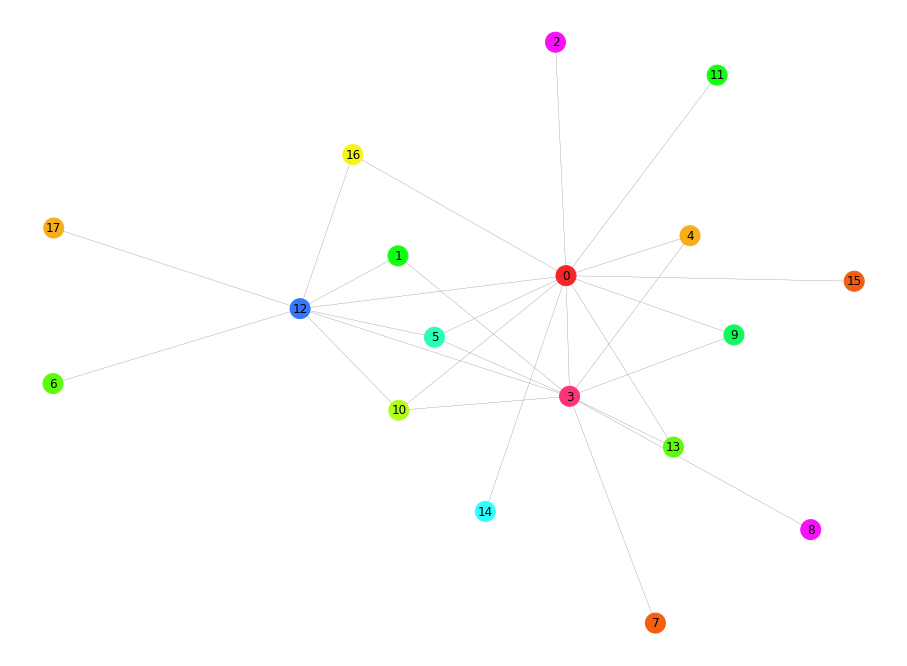

In [35]:
if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    result = [solver.Value(x) for x in pci]
else:
    result = [1 for x in range(size)]
    
# Create a distinct color for each PCI
colors = get_colors(pci_len)
    
G = nx.Graph()
G.add_nodes_from(vertices.index.tolist())
G.add_edges_from(edges.values.tolist())
    
plt.figure(figsize=(16,12))
nx.draw_networkx(G, with_labels=True, node_size=400, width=0.3, 
                 edge_color='grey', 
                 layout=nx.spring_layout(G, k=0.1, iterations=50), 
                 node_color=[colors[i] for i in result])
plt.axis('off')
plt.show()

A know solution on the complete dataset:

2262 cells, 73030 edges, 317522 unique constraints, 191 used PCIs, execution time 10s